In [1]:
#Import modules
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier
#Performance Measurement Modules
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
#Modules for encoding categorical features
from sklearn.preprocessing import StandardScaler, LabelEncoder

#pdbbox for interpretation
from pdpbox import pdp, info_plots

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")

# Load Data

The dataset used here on student performance is from [Kaggle](https://www.kaggle.com/spscientist/students-performance-in-exams). This dataset consists of the marks secured by students in various subjects such as math, reading and writing. This raw dataset is stored in the file `StudentsData.csv`. 

The scores are then converted to grades so that we can train classifiers to predict the student grades for various subjects. The conversion is as follows:
```
Grade A: score >= 80
Grade B: 60 <= score < 80
Grade C: 40 <= score < 60
Grade F: score < 40
```

In [2]:
#Modify the path to reflect the location of the data file
df = pd.read_csv('./StudentsData.csv')

In [3]:
#Display the meta data of the features
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
#Size of the data set
len(df)

1000

In [5]:
#A function to categorize the numerical grades to letter grades
def score_to_grade(score):
    if score >= 80:
        return 'A'
    if score >= 60:
        return 'B'
    if score >= 40:
        return 'C'
    return 'F'

In [6]:
#Convert numerical grades to categorical letter grades and add three new features
df['math grade'] = df['math score'].apply(score_to_grade)
df['reading grade'] = df['reading score'].apply(score_to_grade)
df['writing grade'] = df['writing score'].apply(score_to_grade)
#Display the modified data set
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math grade,reading grade,writing grade
0,female,group B,bachelor's degree,standard,none,72,72,74,B,B,B
1,female,group C,some college,standard,completed,69,90,88,B,A,A
2,female,group B,master's degree,standard,none,90,95,93,A,A,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,C,C,C
4,male,group C,some college,standard,none,76,78,75,B,B,B


# Perform Exploratory Data Analysis

In [7]:
#Determine the student gender distribution
df['gender'].value_counts() / len(df) * 100

gender
female    51.8
male      48.2
Name: count, dtype: float64

In [8]:
#A function to create bar charts
def plot_vc_bar_charts(df, col, ax, color='b'):
    df_vc = df[col].value_counts() / len(df) * 100
    df_vc = df_vc.reset_index()
    df_vc = df_vc.rename(columns={'count': 'pc'})
    
    bar_width = 0.35
    opacity = 0.9
    labels = df_vc[col].values
    capitalized_labels = []
    for label in labels:
        words = label.split(' ')
        capitalized_label = ' '.join([w.capitalize() for w in words])
        capitalized_labels.append(capitalized_label)
    sizes = df_vc['pc'].values
    index = np.arange(len(sizes))
    
    ax.bar(index, sizes, bar_width,
           alpha=opacity,
           label=labels,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(capitalized_labels)
    ax.grid(True);

In [9]:
print(df.columns)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'math grade', 'reading grade', 'writing grade'],
      dtype='object')


0      group B
1      group C
2      group B
3      group A
4      group C
        ...   
995    group E
996    group C
997    group C
998    group D
999    group D
Name: race/ethnicity, Length: 1000, dtype: object


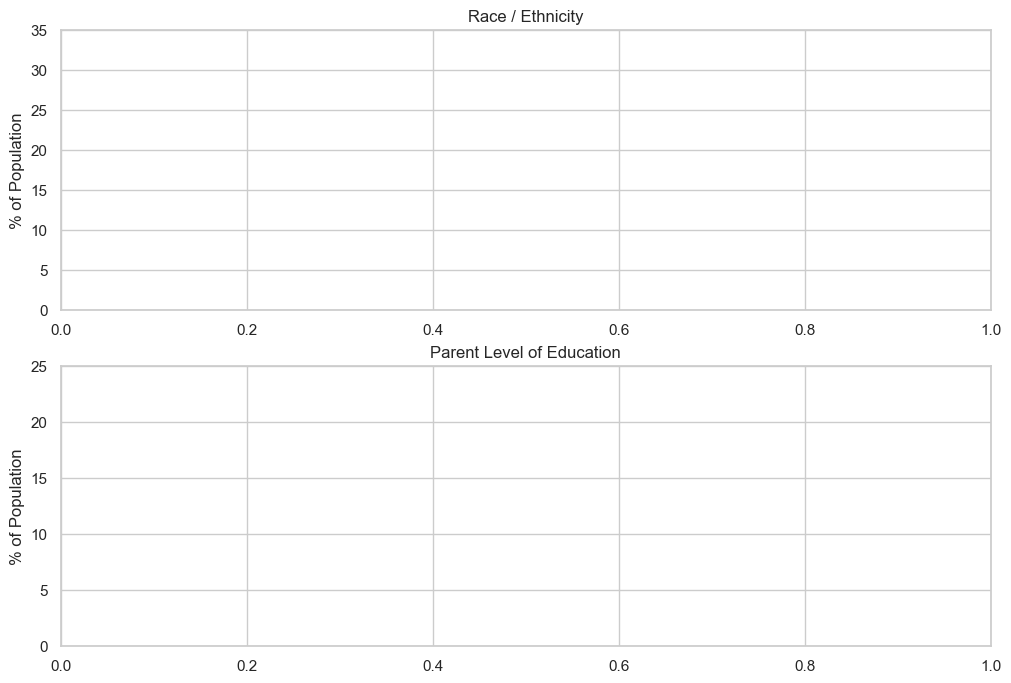

In [ ]:
print(df['race/ethnicity'])
#Display the distribution of Ethnicity and Parent level of Education
f, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_vc_bar_charts(df, 'race/ethnicity', ax=ax[0], color='r')
plot_vc_bar_charts(df, 'parental level of education', ax=ax[1], color='g')
ax[0].set_title('Race / Ethnicity')
ax[1].set_title('Parent Level of Education');
ax[0].set_ylabel('% of Population');
ax[1].set_ylabel('% of Population');
ax[0].set_ylim([0, 35])
ax[1].set_ylim([0, 25]);

In [11]:
#A function to compute the statistical distribution of features
def get_stats(df, grade_col):
    df_grade = df.groupby([grade_col]).agg({'lunch': 'count'}).reset_index()
    df_grade = df_grade.rename(columns={'lunch': 'count'})
    df_grade['pc'] = df_grade['count'] / len(df) * 100
    
    df_gender = df.groupby(['gender', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_gender = df_gender.rename(columns={'lunch': 'count'})
    df_gender['pc'] = df_gender['count'] / len(df) * 100
    
    df_race = df.groupby(['race/ethnicity', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_race = df_race.rename(columns={'lunch': 'count'})
    df_race['pc'] = df_race['count'] / len(df) * 100
    
    df_parent = df.groupby(['parental level of education', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_parent = df_parent.rename(columns={'lunch': 'count'})
    df_parent['pc'] = df_parent['count'] / len(df) * 100
    
    df_lunch = df.groupby(['lunch', grade_col]).agg({'gender': 'count'}).reset_index()
    df_lunch = df_lunch.rename(columns={'gender': 'count'})
    df_lunch['pc'] = df_lunch['count'] / len(df) * 100
    
    df_test_prep = df.groupby(['test preparation course', grade_col]).agg({'gender': 'count'}).reset_index()
    df_test_prep = df_test_prep.rename(columns={'gender': 'count'})
    df_test_prep['pc'] = df_lunch['count'] / len(df) * 100
    
    return df_grade, df_gender, df_race, df_parent, df_lunch, df_test_prep

In [12]:
#Compute the statistical distribution with respect to each subject grades
df_grade_math, df_gender_math, df_race_math, df_parent_math, df_lunch_math, df_test_prep_math = get_stats(df, 'math grade')
df_grade_reading, df_gender_reading, df_race_reading, df_parent_reading, df_lunch_reading, df_test_prep_reading = get_stats(df, 'reading grade')
df_grade_writing, df_gender_writing, df_race_writing, df_parent_writing, df_lunch_writing, df_test_prep_writing = get_stats(df, 'writing grade')

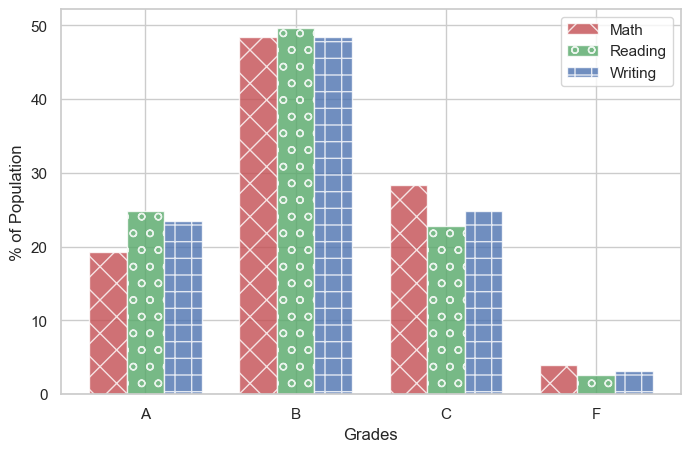

In [13]:
#Plot the distribution of the students grades
fig, ax = plt.subplots(figsize=(8, 5))
grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.25

opacity = 0.8
error_config = {'ecolor': '0.3'}

ax.bar(index, df_grade_math['pc'], bar_width,
       alpha=opacity, color='r',
       label='Math',
       hatch='x')
ax.bar(index + bar_width, df_grade_reading['pc'], bar_width,
       alpha=opacity, color='g',
       label='Reading',
       hatch='o')
ax.bar(index + bar_width * 2, df_grade_writing['pc'], bar_width,
       alpha=opacity, color='b',
       label='Writing',
       hatch='+')

ax.set_xlabel('Grades')
ax.set_ylabel('% of Population')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(grades)
ax.legend()
ax.grid(True);

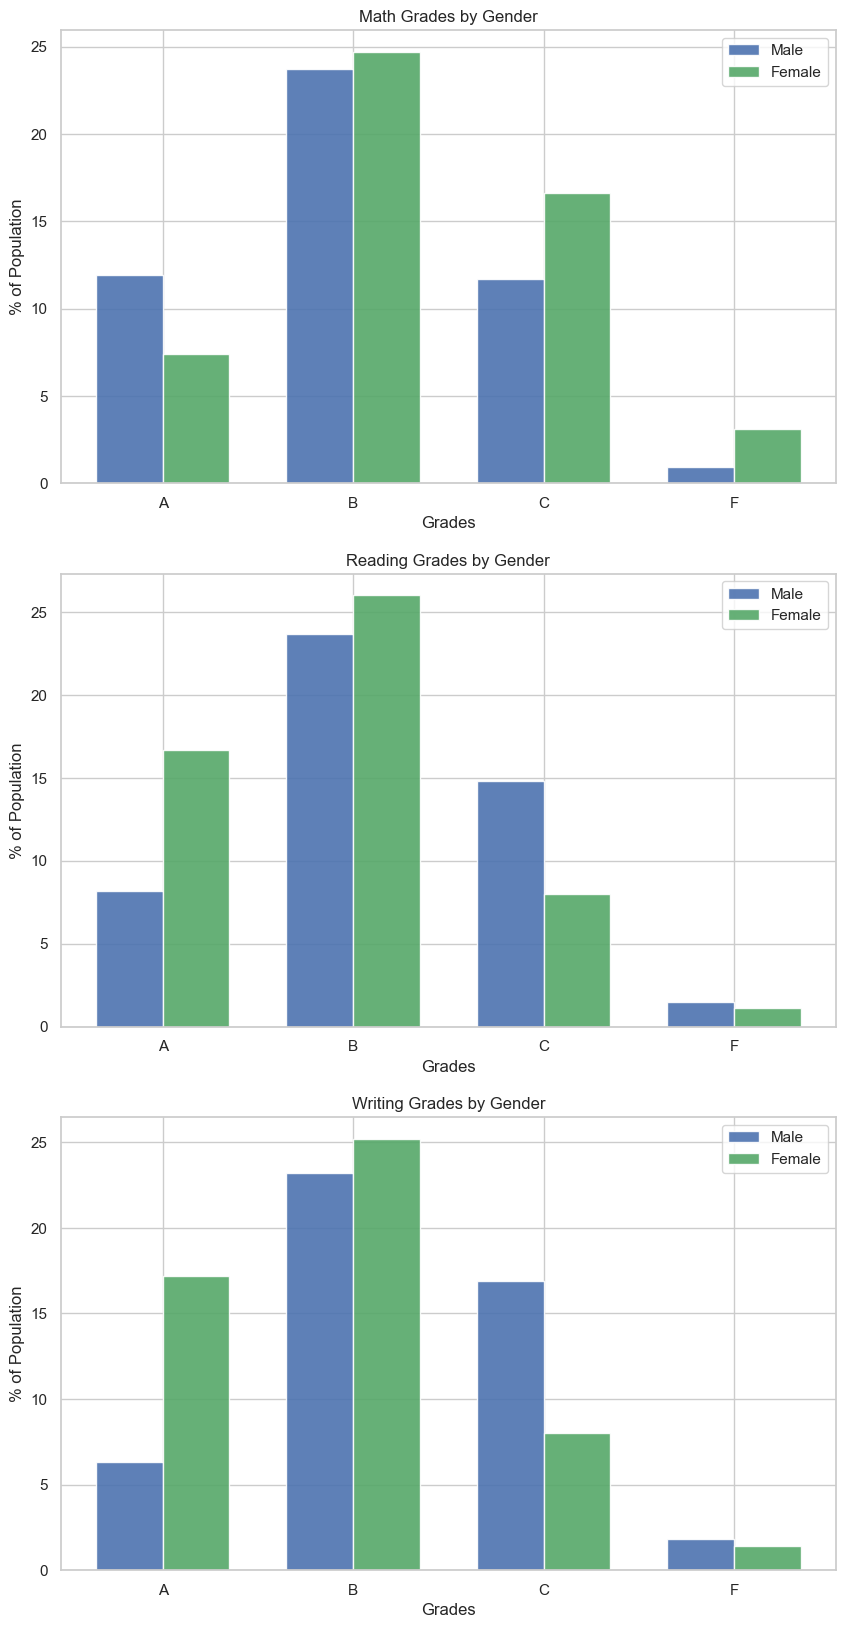

In [14]:
#Grades distribution by Gender
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.9
error_config = {'ecolor': '0.3'}

ax[0].bar(index, df_gender_math[df_gender_math['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[0].bar(index + bar_width, df_gender_math[df_gender_math['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[0].set_xlabel('Grades')
ax[0].set_ylabel('% of Population')
ax[0].set_title('Math Grades by Gender')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

ax[1].bar(index, df_gender_reading[df_gender_reading['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[1].bar(index + bar_width, df_gender_reading[df_gender_reading['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[1].set_xlabel('Grades')
ax[1].set_ylabel('% of Population')
ax[1].set_title('Reading Grades by Gender')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

ax[2].bar(index, df_gender_writing[df_gender_writing['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[2].bar(index + bar_width, df_gender_writing[df_gender_writing['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population')
ax[2].set_title('Writing Grades by Gender')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);

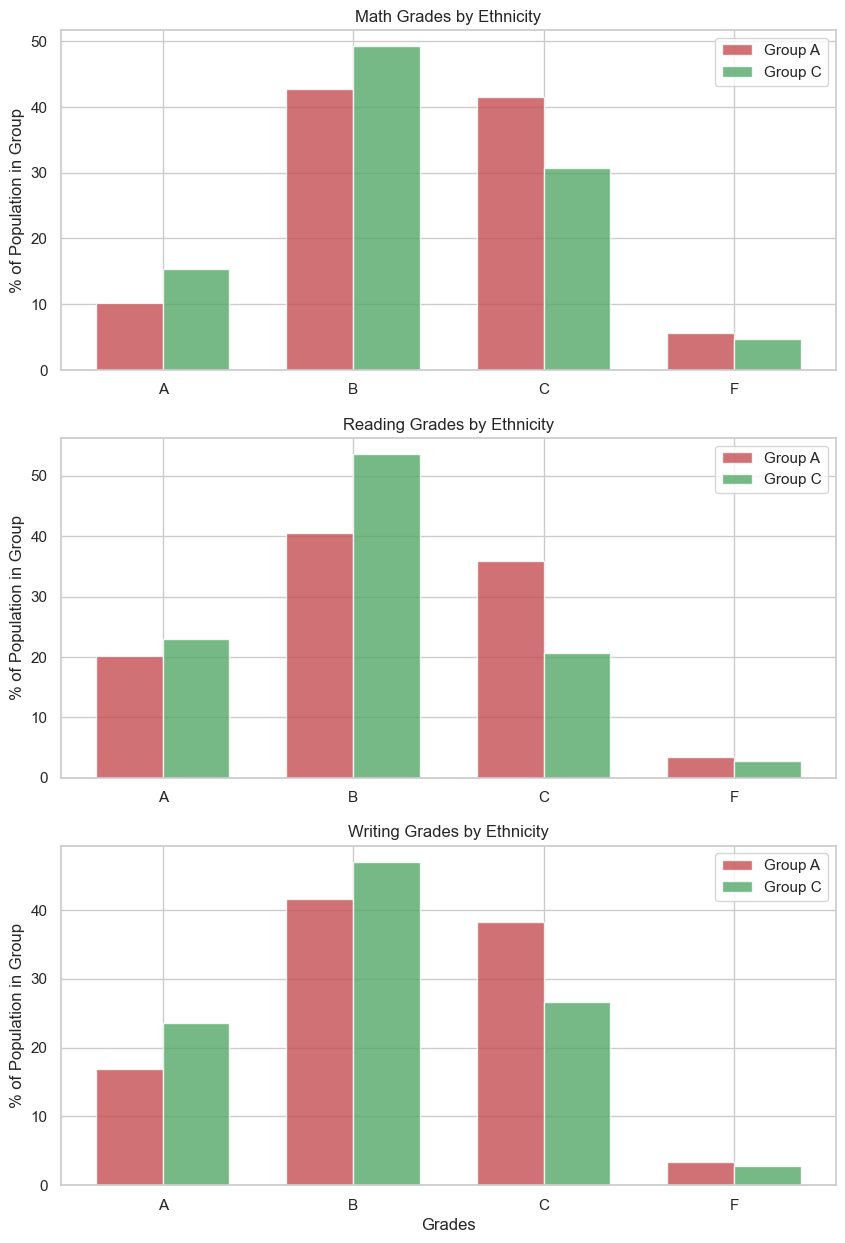

In [15]:
##Grades distribution by Ethnicity
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'].sum()
math_c_sum = df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'].sum()
ax[0].bar(index, df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[0].bar(index + bar_width, df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'] / math_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Ethnicity')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

read_a_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'].sum()
read_c_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'].sum()
ax[1].bar(index, df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[1].bar(index + bar_width, df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'] / read_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Ethnicity')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

write_a_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'].sum()
write_c_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'].sum()
ax[2].bar(index, df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[2].bar(index + bar_width, df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'] / write_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Ethnicity')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);

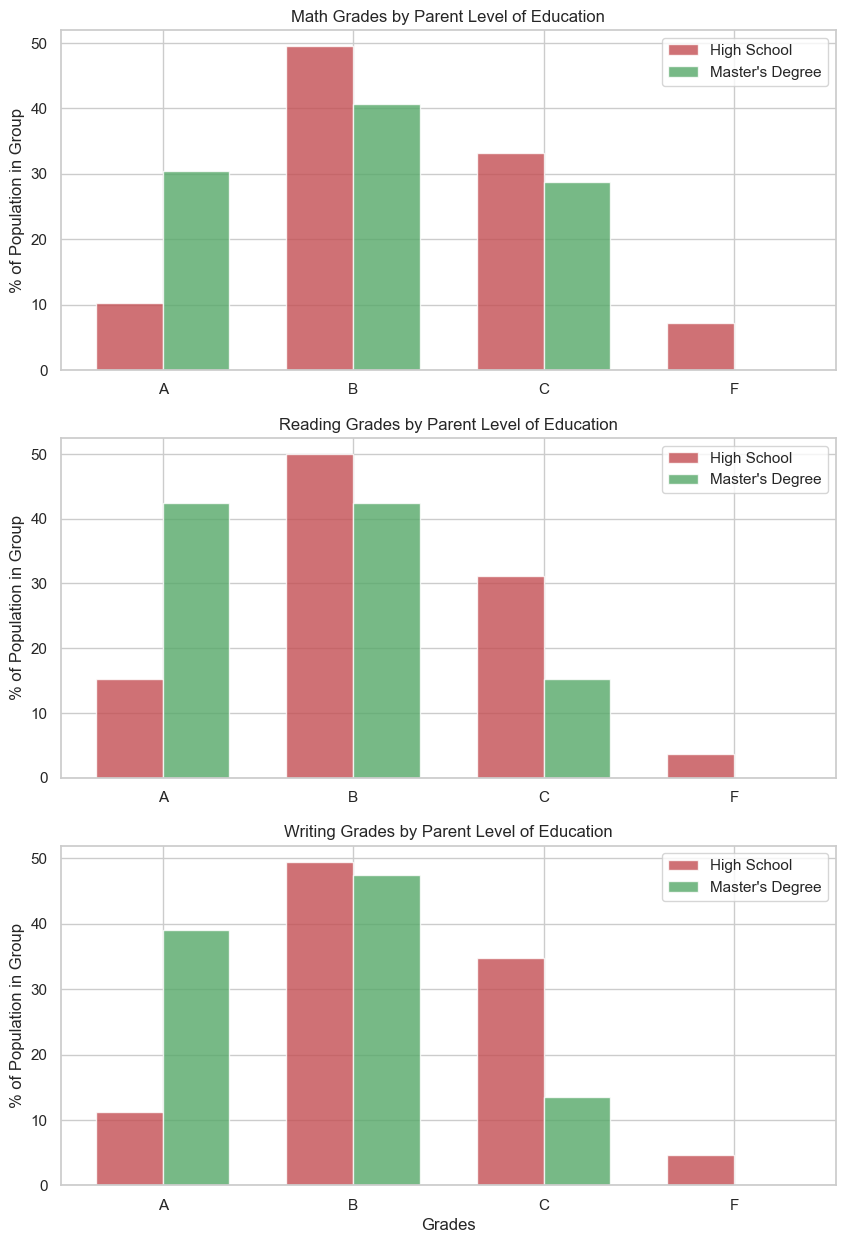

In [16]:
#Grades distribution by Parents level of Education
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'].sum()
math_c_sum = df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].sum()
math_ma_pc = np.array(df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].values) / math_c_sum * 100
math_ma_pc = np.append(math_ma_pc, 0) # for grade f
ax[0].bar(index, df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[0].bar(index + bar_width, 
          math_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Parent Level of Education')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

read_a_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'].sum()
read_c_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].sum()
read_ma_pc = np.array(df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].values) / read_c_sum * 100
read_ma_pc = np.append(read_ma_pc, 0) # for grade f
ax[1].bar(index, df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[1].bar(index + bar_width, read_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Parent Level of Education')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

write_a_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'].sum()
write_c_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].sum()
write_ma_pc = np.array(df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].values) / write_c_sum * 100
write_ma_pc = np.append(write_ma_pc, 0) # for grade f
ax[2].bar(index, df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[2].bar(index + bar_width, write_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Parent Level of Education')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);

# Data Preparation

In [17]:
#Create a list of parent level education level
ple = ['high school', 'some high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]
#Create an array to map the index of the parent level of education in the list ple
ple_map = {}
for idx, p in enumerate(ple):
    ple_map[p] = idx

In [18]:
#First, encode the categorical input features using LabelEncoder objects
"""LabelEncoder is the utility class sklearn.preprocessing.LabelEncoder that helps normalize labels 
such that they contain only values 0 and n_classes-1"""
#Create LabelEncoder objects for each input categorical features



#Call the method fit on the each labelencoder object for a feature




"""call the method transform on the labelencoder object of a feature 
to store the transformed categorical feature in the dataframe"""






'call the method transform on the labelencoder object of a feature \nto store the transformed categorical feature in the dataframe'

In [19]:
#Encode the target variables using LabelEncoder objects
#Create LabelEncoder objects for each categorical target variables



#Call the method fit on the each labelencoder object for a target variable


"""call the method transform on the labelencoder object of a target variable 
to store the transformed target variable in the dataframe"""


'call the method transform on the labelencoder object of a target variable \nto store the transformed target variable in the dataframe'

In [20]:
#Display the encoded categorical input features and target variables
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math grade,reading grade,writing grade
0,female,group B,bachelor's degree,standard,none,72,72,74,B,B,B
1,female,group C,some college,standard,completed,69,90,88,B,A,A
2,female,group B,master's degree,standard,none,90,95,93,A,A,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,C,C,C
4,male,group C,some college,standard,none,76,78,75,B,B,B


# Creating a Math Grade RandomForest Model

In [21]:
#Split dataset into two datasets for building a RandomForest to predict the math test grades
#The first dataset will be used for training and validation which the second is for testing
#Using the train_test_split function split the dataset in 80 to 20 ratio
"""The parameter stratify ensures the training and validation data set 
    to have same percantage of sample classes of each target class"""
df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['math_grade_le'], 
                                         shuffle=True, random_state=42)
df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

KeyError: 'math_grade_le'

In [ ]:
#Create training+validation and test datasets
feature_cols = ['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']
X_train_val = df_train_val[feature_cols]
X_test = df_test[feature_cols]
y_math_train_val = df_train_val['math_grade_le']
y_reading_train_val = df_train_val['reading_grade_le']
y_writing_train_val = df_train_val['writing_grade_le']
y_math_test = df_test['math_grade_le']
y_reading_test = df_test['reading_grade_le']
y_writing_test = df_test['writing_grade_le']

In [ ]:
#A function to create random forest model with desired number of decision trees and impurity function
"""n_estimators input desired number of decision trees
    max_depth controls the depth of each tree
    criterion defines the type of impurity function
    n_jobs defines the number of trees to be run in parallel"""
def create_random_forest_model(n_estimators, 
                               max_depth=10,
                               criterion='gini',
                               random_state=42,
                               n_jobs=4):
    #Return a RandomForestClassifier Object


In [ ]:
"""Create the random forest model to predict grades in mathematics 
    with an ensemble of 50 decision trees,
    and the gini impurity function"""

"""Train the created RandomForest Model using the fit method with
    training+val data"""


In [ ]:
"""Test the mathematics random forest model performance using the 
    predict method and predict_proba (probabilities of classes) methods of RandomForestClassifier Class"""


In [ ]:
#Compute the baseline performance which should be predicting letter grade B


In [ ]:
#Compute prediction accuracy


In [ ]:
#Compute Precision, Recall and F1 Scores since the dataset is imbalanced
from sklearn.metrics import recall_score, precision_score, f1_score
#Use the sklearn.metrics.precision_score method that computes tp / (tp + fp)
#The precision is the ability of the classifier not to label as positive a sample that is negative.



#Use the sklearn.metrics.recall_score method that computes tp / (tp + fn)
#The recall is the ability of the classifier to find all the positive samples.



#Use the sklearn.metrics.f1_score method that computes F1 = 2 * (precision * recall) / (precision + recall)
#The F1 score is a harmonic mean of the precision and recall.





# Creating a Reading Grade RandomForest Model

# Creating a Writing Grade RandomForest Model

## Model Interpretation


## Feature Importance